In [480]:
import numpy as np
import time
from matplotlib import pyplot as plt
import pandas as pd

from scipy.sparse.linalg import svds

In [481]:
class Node:
    def __init__(self, rank = None, sing_val = None, U = None, V = None, size_ = None):
        self.rank, self.sing_val, self.U, self.V, self.size_ = rank, sing_val, U, V, size_
        self.sons = []

In [482]:
def CompressMatrix(A, t_min, t_max, s_min, s_max, U, D, V, r):
    selected_matrix = A[t_min:t_max+1, s_min:s_max+1]
    if( np.allclose(selected_matrix, np.zeros_like(selected_matrix))) :
        v = Node(0, np.array([]), np.array([]), np.array([]), (t_min, t_max, s_min, s_max) )
        return v
    sigma_ = np.diag(D)
    u = Node()
    u.rank = r
    u.sing_val = sigma_[:u.rank]
    u.U = U[:, :u.rank]
    u.V = np.matmul(D[:u.rank, :u.rank], V[:u.rank, :])
    u.size_ = (t_min, t_max, s_min, s_max)
    return u

In [483]:
def CreateTree(A, t_min, t_max, s_min, s_max, r, epsi):
    if t_max-t_min<=r+1 or s_max - s_min <= r+1:
        U, D, V = np.linalg.svd(A[t_min:t_max+1, s_min:s_max+1])
    else:
       U, D, V = svds(A[t_min:t_max+1, s_min:s_max+1], k=r+1)
       U = U[:, ::-1]
       D = D[::-1]
       V =V[::-1, :]
    D_new = np.zeros((D.shape[0], D.shape[0]))
    np.fill_diagonal(D_new, D)
    if (t_max - t_min <= r or s_max - s_min <= r or D_new[r,r] < epsi):
        v = CompressMatrix(A, t_min, t_max, s_min, s_max, U, D_new, V, r)
        return v
    v = Node()
    t_newmax = (t_min + t_max)//2
    s_newmax = (s_min + s_max)//2
    v.sons.append(CreateTree(A, t_min, t_newmax, s_min, s_newmax, r, epsi))
    v.sons.append(CreateTree(A, t_min, t_newmax, s_newmax+1, s_max, r, epsi))
    v.sons.append(CreateTree(A, t_newmax+1, t_max, s_min, s_newmax, r, epsi))
    v.sons.append(CreateTree(A, t_newmax+1, t_max, s_newmax + 1, s_max, r, epsi))
    return v

def CreateTree(A, t_min, t_max, s_min, s_max, r, epsi):
    U, D, V = np.linalg.svd(A[t_min:t_max+1, s_min:s_max+1])
    D_new = np.zeros((D.shape[0], D.shape[0]))
    np.fill_diagonal(D_new, D)
    if(r+1 >= D_new.shape[0] or r+1 >= D_new.shape[1] or D_new[r+1, r+1] < epsi):
        v = CompressMatrix(A, t_min, t_max, s_min, s_max, U, D_new, V, r)
        return v
    v = Node()
    t_newmax = (t_min + t_max)//2
    s_newmax = (s_min + s_max)//2
    v.sons.append(CreateTree(A, t_min, t_newmax, s_min, s_newmax, r, epsi))
    v.sons.append(CreateTree(A, t_min, t_newmax, s_newmax+1, s_max, r, epsi))
    v.sons.append(CreateTree(A, t_newmax+1, t_max, s_min, s_newmax, r, epsi))
    v.sons.append(CreateTree(A, t_newmax+1, t_max, s_newmax + 1, s_max, r, epsi))
    return v


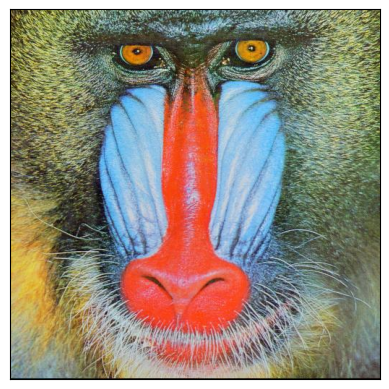

In [484]:
import cv2
Img = cv2.imread("mandril.jpg")
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2RGB)
#Img = Img[:257,:257]
plt.imshow(Img)
plt.xticks([]), plt.yticks([])
plt.show()

In [485]:
r_img = Img[..., 0]
g_img = Img[..., 1]
b_img = Img[..., 2]

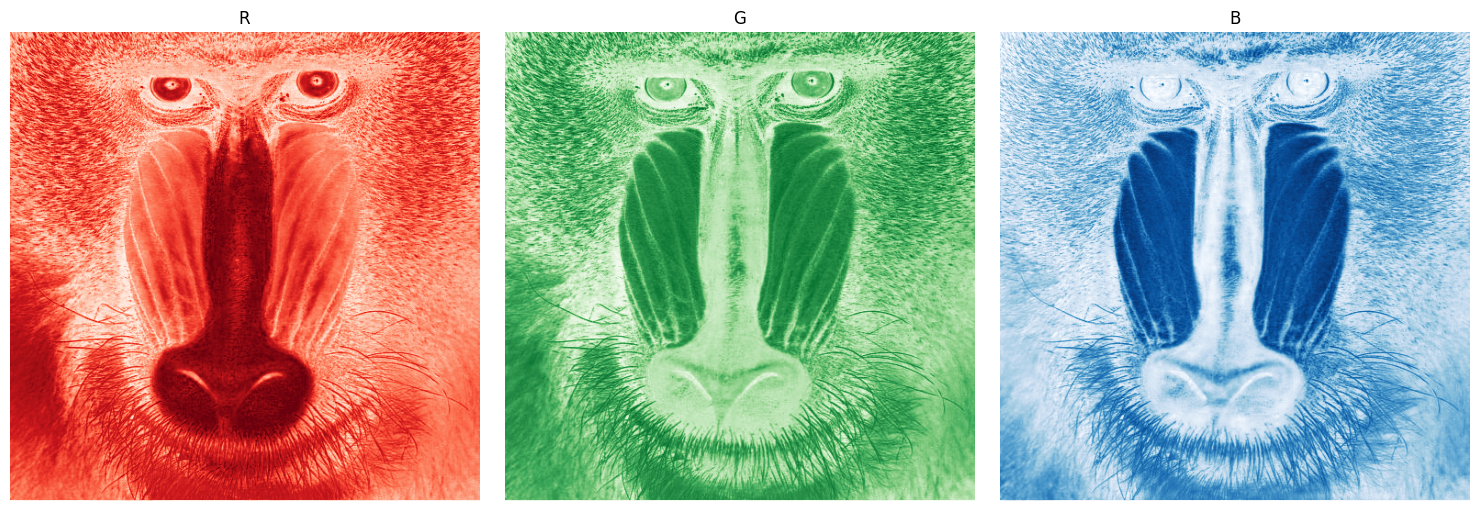

In [486]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(r_img, cmap='Reds')
axes[0].set_title('R')
axes[0].axis('off')
axes[1].imshow(g_img, cmap='Greens')
axes[1].set_title('G')
axes[1].axis('off')
axes[2].imshow(b_img, cmap='Blues')
axes[2].set_title('B')
axes[2].axis('off')

plt.tight_layout()
plt.show()

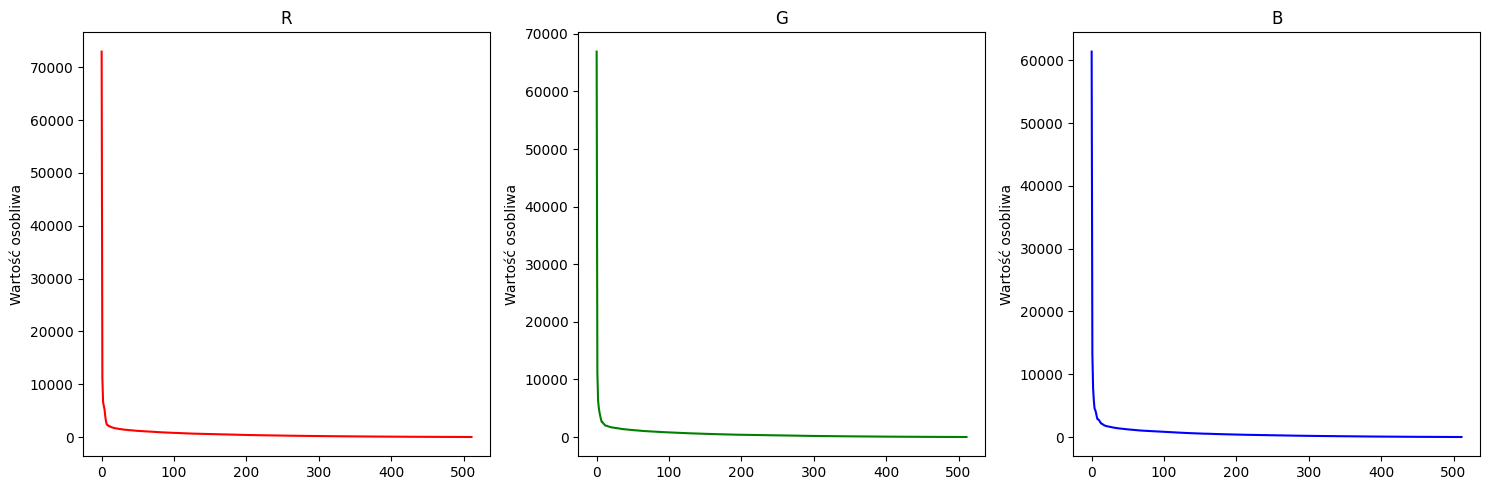

In [487]:
_, D_r, _ = np.linalg.svd(r_img)
_, D_g, _ = np.linalg.svd(g_img)
_, D_b, _ = np.linalg.svd(b_img)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(D_r, color='r')
axes[0].set_title('R')
axes[0].set_ylabel('Wartość osobliwa')

axes[1].plot(D_g, color='g')
axes[1].set_title('G')
axes[1].set_ylabel('Wartość osobliwa')

axes[2].plot(D_b, color='b')
axes[2].set_title('B')
axes[2].set_ylabel('Wartość osobliwa')

plt.tight_layout()
plt.show()

In [488]:
#compress_jp2_r = CreateTree(r_img.astype(float), 0, r_img.shape[0]-1, 0, r_img.shape[1]-1, 1, D_r[-1])
#compress_jp2_g = CreateTree(g_img.astype(float), 0, g_img.shape[0]-1, 0, g_img.shape[1]-1, 4, 1e-3)
#compress_jp2_b = CreateTree(b_img.astype(float), 0, b_img.shape[0]-1, 0, b_img.shape[1]-1, 4, 1e-3)

In [489]:
def draw_matrix(u,M):
    if len(u.sons)==0:
        M[u.size_[0]:u.size_[0]+u.rank, u.size_[2]:u.size_[3]+1] = 0
        M[u.size_[0]:u.size_[1]+1, u.size_[2]:u.size_[2]+u.rank] = 0
    else:
        for s in u.sons:
            draw_matrix(s,M)

In [490]:
def draw_bitmap(u, M):
    if len(u.sons)==0:
        M_reconstructed = np.matmul(u.U, u.V)
        M[u.size_[0]:u.size_[1]+1, u.size_[2]:u.size_[3]+1] = M_reconstructed
    else:
        for s in u.sons:
            draw_bitmap(s,M)


In [491]:
def compression(A,r,eps):
    tree = CreateTree(A.astype(float), 0, A.shape[0]-1, 0, A.shape[1]-1, r, eps)
    A_compressed = np.ones_like(A)
    draw_matrix(tree, A_compressed)
    A_reconstructed = np.zeros_like(A)
    draw_bitmap(tree, A_reconstructed)
    return A_compressed, A_reconstructed


In [492]:
def visualize_compression_reconstruction(r, eps_ind):
    fig, axes = plt.subplots(3, 2, figsize=(10, 10))
    
    images = [r_img, g_img, b_img]
    colors = ['Reds', 'Greens', 'Blues']
    
    reconstructed_images = [[],[],[]] 

    for i, img in enumerate(images):
        _, D, _ = np.linalg.svd(img)
        
        A_compressed, A_reconstructed = compression(img, r, D[eps_ind])
        
        axes[i, 0].imshow(A_compressed, cmap="gray")
        axes[i, 0].set_title(f"Macierz kompresji {colors[i]}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(A_reconstructed, cmap=colors[i])
        axes[i, 1].set_title(f"Wynik {colors[i]}")
        axes[i, 1].axis('off')

        reconstructed_images[i].append(A_reconstructed)

    plt.suptitle(f"Komprecja i rekonstrukcja obrazów RGB, r = {r}, eps = D[{eps_ind}]", fontsize=16)

    plt.tight_layout()
    plt.show()

    rgb_image = np.stack([reconstructed_images[0][0], reconstructed_images[1][0], reconstructed_images[2][0]], axis=-1)
    plt.figure(figsize=(8, 4)) 
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title("Wynikowa bitmapa")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Img)
    plt.title("Oryginalny obraz")
    plt.axis('off')


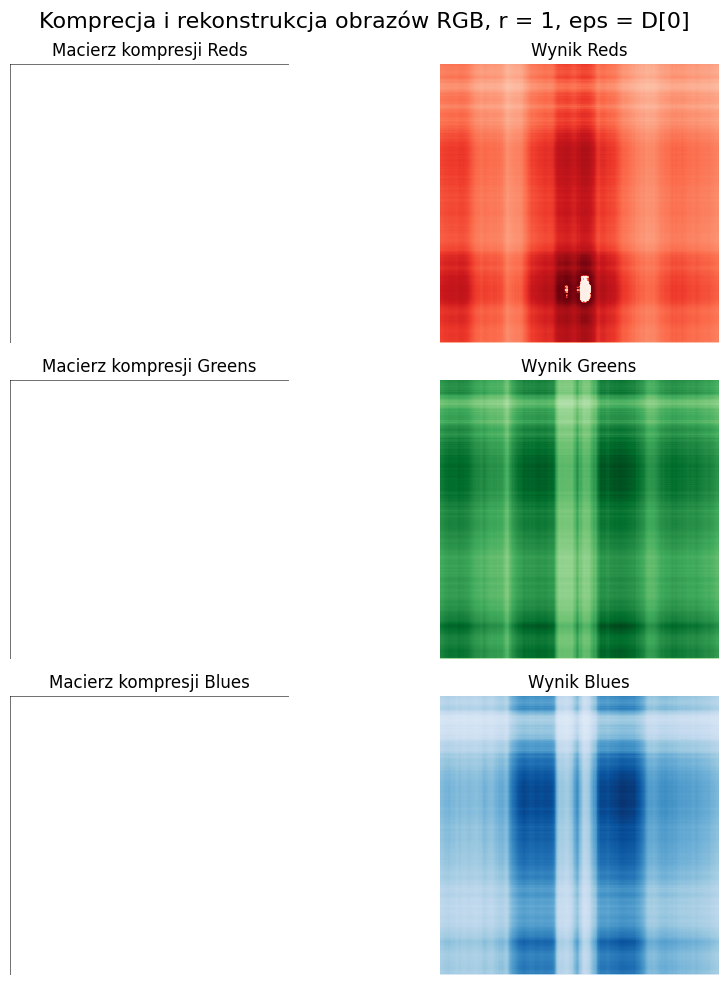

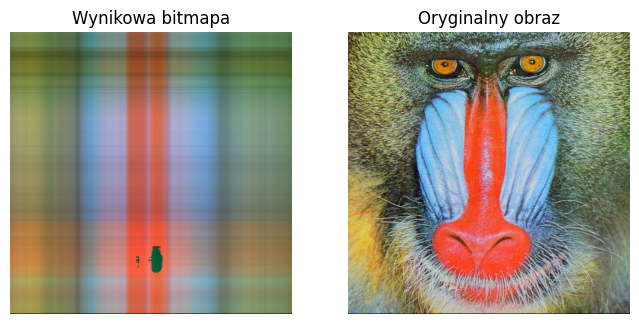

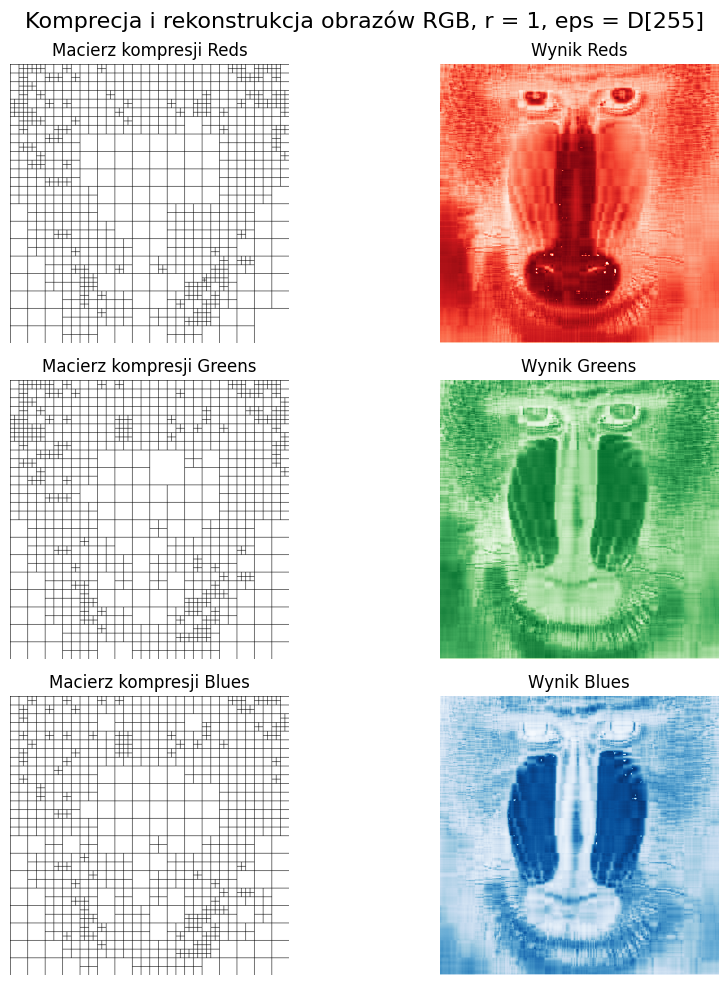

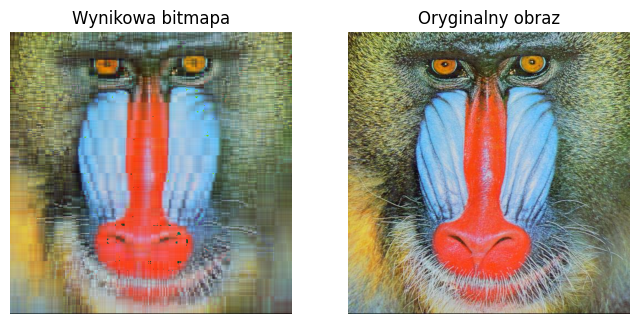

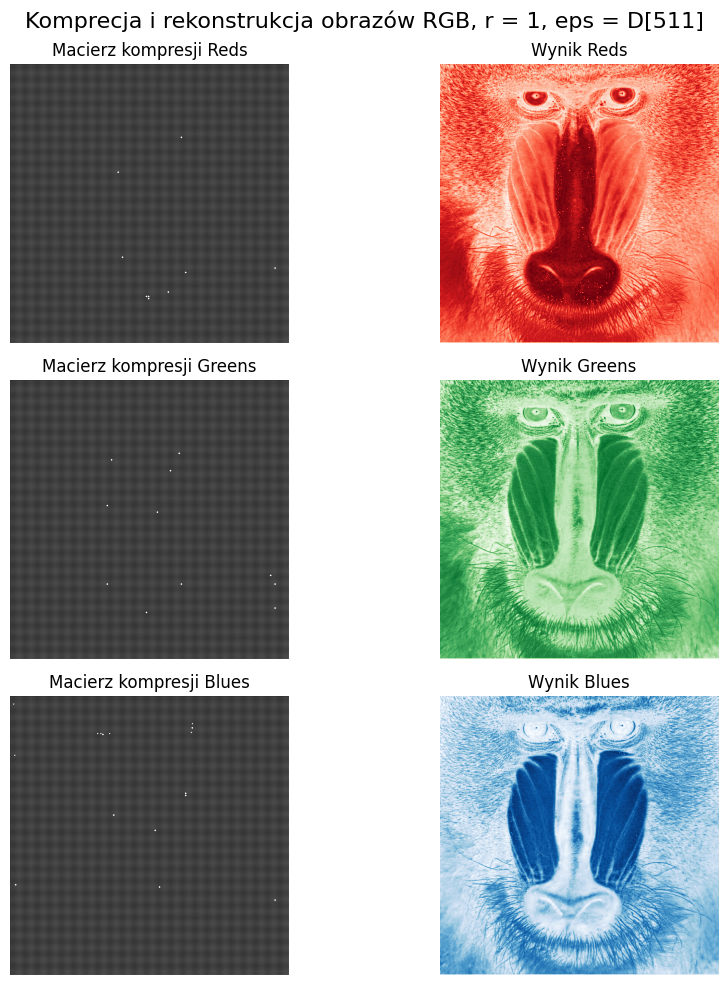

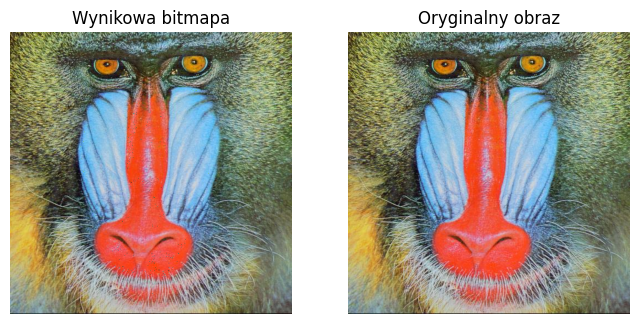

In [493]:
r = 1
eps_ind = 0

visualize_compression_reconstruction(r, eps_ind)

r = 1
eps_ind = 255

visualize_compression_reconstruction(r, eps_ind)

r = 1
eps_ind = 511

visualize_compression_reconstruction(r, eps_ind)

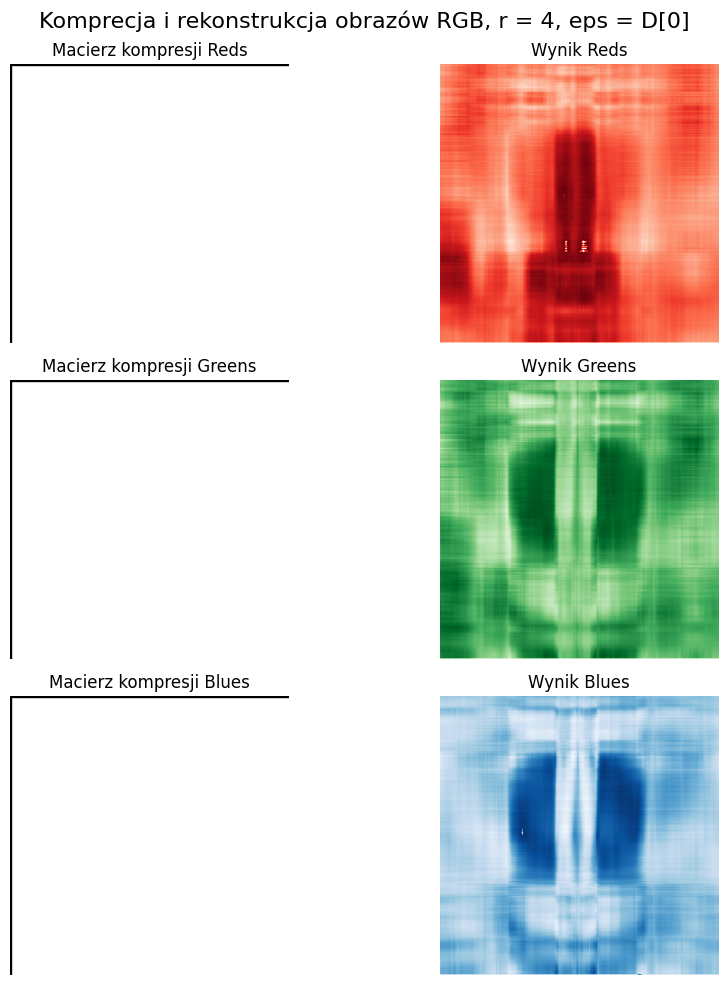

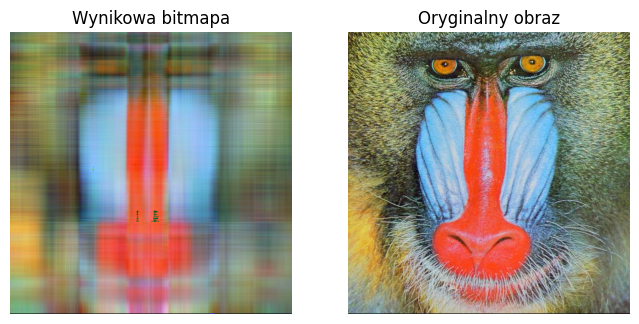

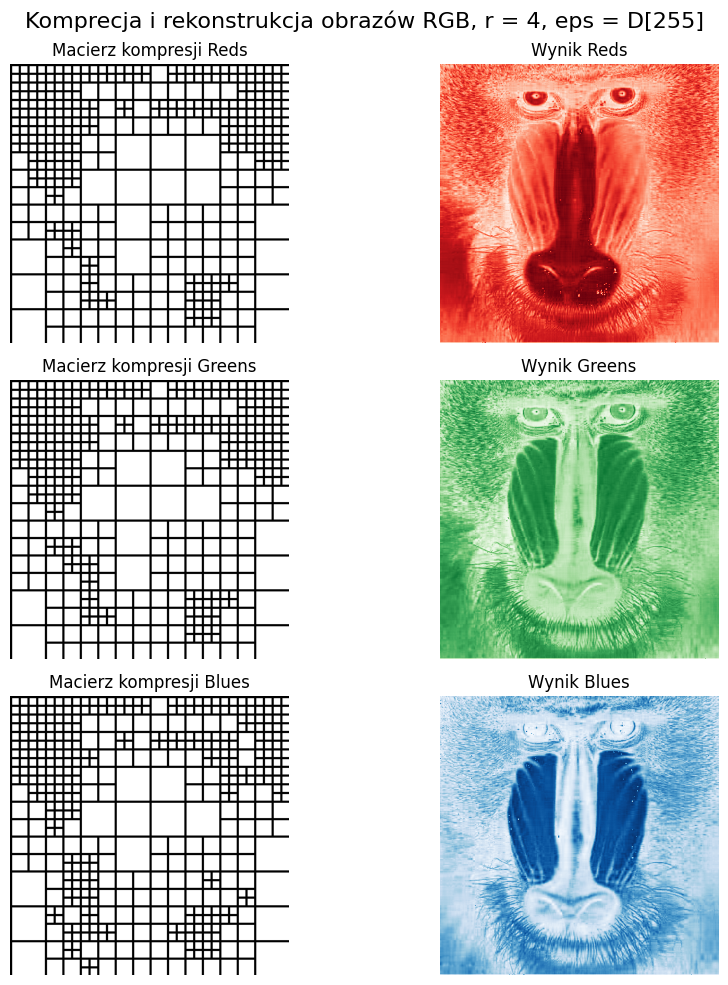

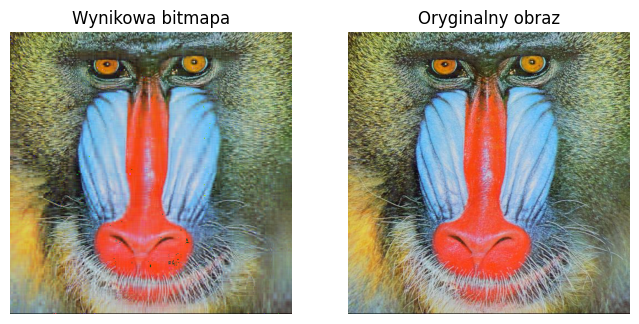

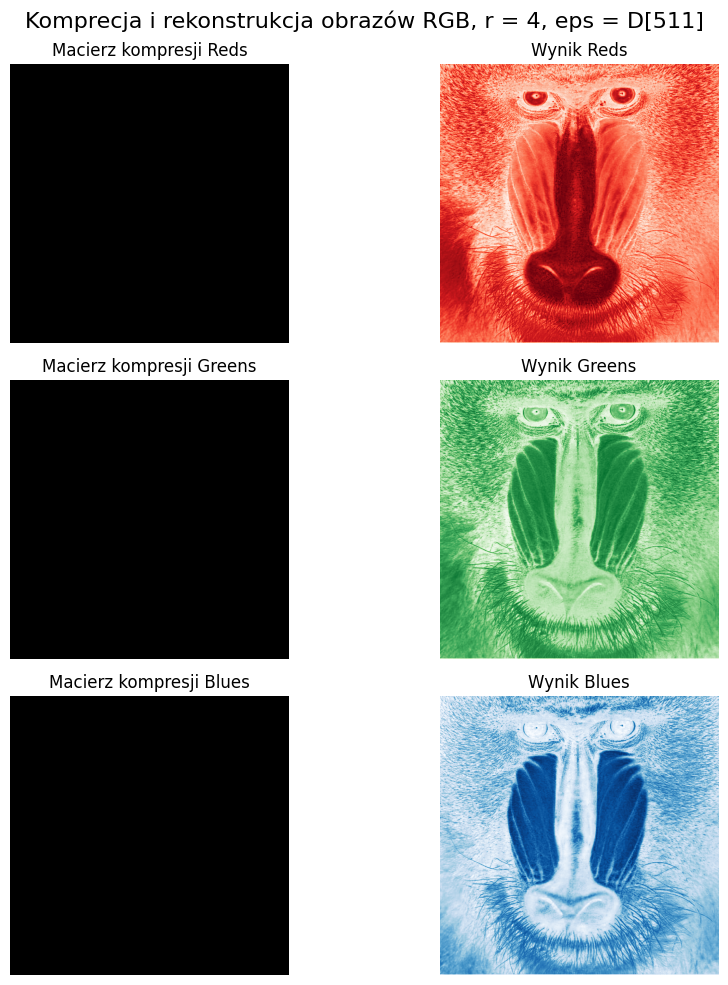

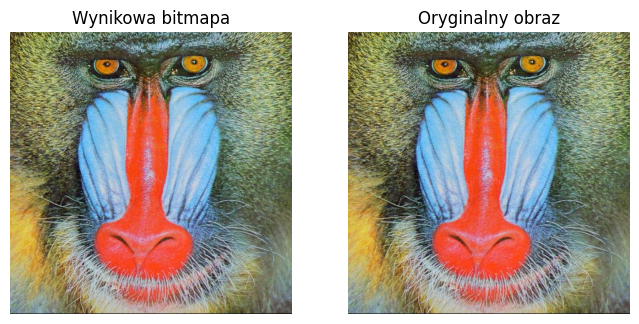

In [494]:
r = 4
eps_ind = 0

visualize_compression_reconstruction(r, eps_ind)

r = 4
eps_ind = 255

visualize_compression_reconstruction(r, eps_ind)

r = 4
eps_ind = 511

visualize_compression_reconstruction(r, eps_ind)